# Hair Segmentation 

In [1]:
import os
import numpy as np
import torch
import torch.utils.data as td
from PIL import Image
import matplotlib.pyplot as plt
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
collab = False

cpu


In [51]:
# a = torch.rand(4,4)
# print(a.cuda())

## Import dataset

In [2]:
# Dataset class
class HairDataset(td.Dataset):
    
    #mode should be 'Training' or 'Testing'
    def __init__(self, img_dir, gt_dir, mode='Training', image_size=(128, 128)):
        super(HairDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.images_dir = os.path.join(img_dir, mode)
        self.images = sorted(os.listdir(self.images_dir))
        self.targets_dir = os.path.join(gt_dir, mode)
        self.targets = sorted(os.listdir(self.targets_dir))        
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])    
        img = np.asarray(Image.open(img_path).resize(self.image_size).convert('RGB'))/255
        target_path = os.path.join(self.targets_dir, self.targets[idx])    
        target = np.asarray(Image.open(target_path).resize(self.image_size).convert('RGB'))/255
        return img, target

In [9]:
# define dataset dir path
if collab is False:
    root_dir = '/home/ndo001/Courses/project/hair-seg-project'
else :
    root_dir = '/'
    !unzip /Figaro1k.zip -d /


img_dir = os.path.join(root_dir, 'Figaro1k/Original')
gt_dir = os.path.join(root_dir, 'Figaro1k/GT')

# build training and testing set
train_set =  HairDataset(img_dir=img_dir, gt_dir=gt_dir, mode='Training')
test_set =  HairDataset(img_dir=img_dir, gt_dir=gt_dir, mode='Testing')
print("Nombre d'images dans le training set :", len(train_set))
print("Nombre d'images dans le testing set :", len(test_set))

# Seperate orignals and ground truth
def image_mask_separator(set):
    X = []
    y = []
    for image, mask in train_set:
        X.append(image)
        y.append(mask[:,:,0])
    return np.array(X), np.array(y)

X_train, y_train = image_mask_separator(train_set)
X_test, y_test = image_mask_separator(test_set)

# visualize images
def visualize_data(images, axes):
    img, target = images[0], images[1]
    axes[0].imshow(img)
    axes[0].set_title('Original image')
    axes[0].axis('off')
    axes[1].imshow(target)
    axes[1].set_title('Ground truth image')
    axes[1].axis('off')

fig, axes = plt.subplots(ncols=2)
visualize_data(train_set[5], axes)


/home/ndo001/Courses/project/hair-seg-project/Figaro1k/Original


FileNotFoundError: [Errno 2] No such file or directory: '/home/ndo001/Courses/project/hair-seg-project/Figaro1k/Original/Training'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.48257852097816
(128, 128, 3)


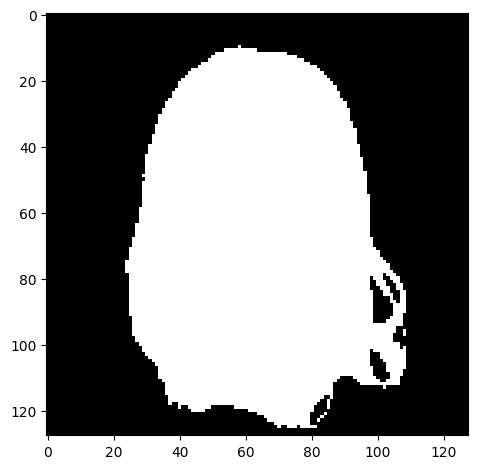

In [54]:
y = (y_train[5] * 255.)[:,:,np.newaxis]

index = np.where(X_train[0] != 0)[0]

y = np.repeat(y, 3, axis=2)
print(y.shape)
plt.imshow(y)
plt.tight_layout()

## Create CNN

In [55]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.losses import BinaryCrossentropy


In [56]:
# Architecture from https://www.kaggle.com/code/rahuldshetty/hair-segmentation-using-u-net/notebook
inputs = Input((128, 128, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)

In [57]:
up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6a), conv4], axis=3) #Was conv5 instead of conv6a
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['acc'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_92 (Conv2D)             (None, 128, 128, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_92[0][0]']              
                                )                                                           

## Train NN

In [58]:
#Create directory to save model and history
num_train = 0
while os.path.isdir(os.path.join(root_dir, 'training_{i}'.format(i=num_train))):
    num_train +=1
save_dir = os.path.join(root_dir, 'training_{i}'.format(i=num_train))
os.makedirs(save_dir)

#train model
epochs = 50
history = model.fit(X_train,y_train,validation_split=0.15,epochs=epochs,batch_size=64,)
model.save(os.path.join(save_dir, 'model.h5'))
np.save(os.path.join(save_dir, 'my_history.npy') ,history)
    

Epoch 1/50
12/12 [==============================] - 65s 5s/step - loss: 1.7697 - acc: 0.5550 - val_loss: 0.6989 - val_acc: 0.6608
Epoch 2/50
12/12 [==============================] - 64s 5s/step - loss: 0.7373 - acc: 0.5965 - val_loss: 0.6189 - val_acc: 0.7193
Epoch 3/50
12/12 [==============================] - 64s 5s/step - loss: 0.6342 - acc: 0.6464 - val_loss: 1.5127 - val_acc: 0.5317
Epoch 4/50
12/12 [==============================] - 64s 5s/step - loss: 0.7931 - acc: 0.6217 - val_loss: 0.6819 - val_acc: 0.5662
Epoch 5/50
12/12 [==============================] - 64s 5s/step - loss: 0.6766 - acc: 0.6031 - val_loss: 0.5859 - val_acc: 0.7200
Epoch 6/50
12/12 [==============================] - 64s 5s/step - loss: 0.6299 - acc: 0.6418 - val_loss: 0.5906 - val_acc: 0.6736
Epoch 7/50
12/12 [==============================] - 64s 5s/step - loss: 0.6134 - acc: 0.6378 - val_loss: 0.5673 - val_acc: 0.6973
Epoch 8/50
12/12 [==============================] - 64s 5s/step - loss: 0.6102 - acc: 0.64

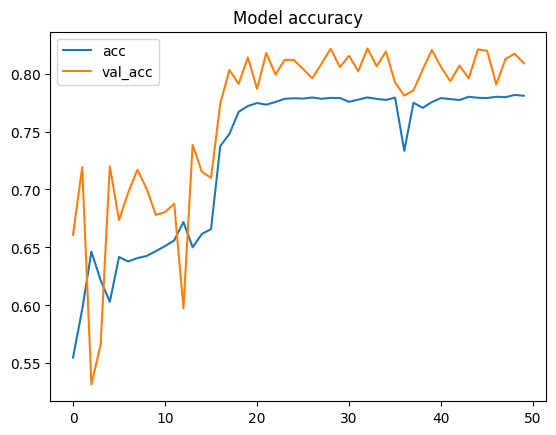

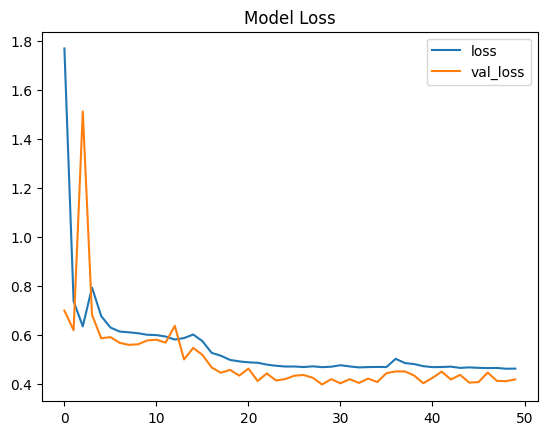

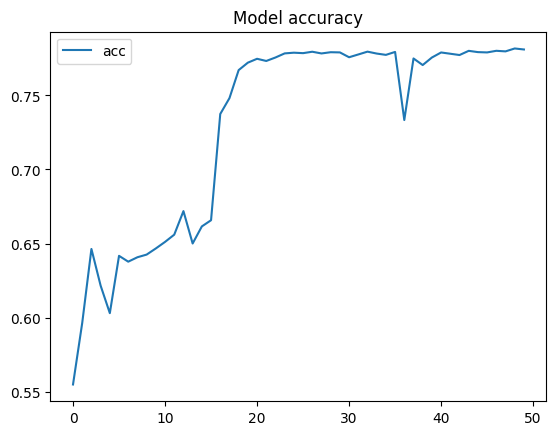

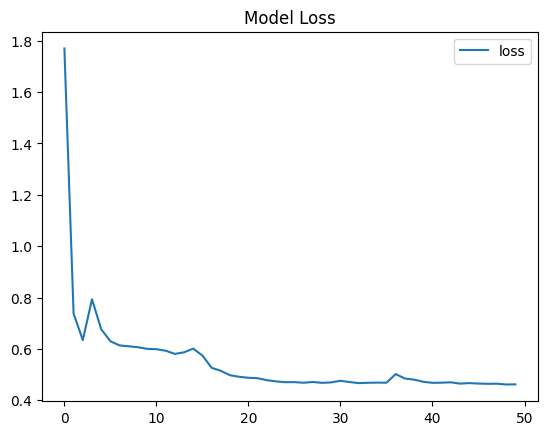

In [59]:
#history=np.load('bce_50epochs_conv6a_history.npy',allow_pickle='TRUE').item()

# Must have been training during this execution
h = history
plt.plot(h.history['acc'], label='acc')
plt.plot(h.history['val_acc'], label='val_acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.legend()
plt.show()

plt.plot(h.history['acc'], label='acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.legend()
plt.title('Model Loss')
plt.show()

## Predict single image

(840, 128, 128, 3)
(1, 128, 128, 3)
1/1 [==============================] - 0s 197ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 128, 128, 1)
(128, 128, 3)
(128, 128)


Text(0.5, 1.0, 'predict')

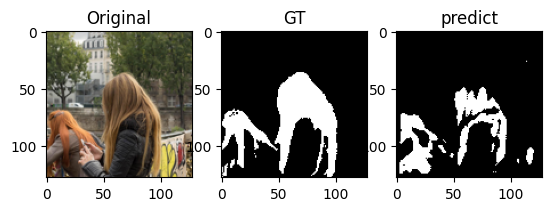

In [63]:
#Load trained model if necessary
#model = load_model('bce_50epochs_conv6a_model.h5')

idx = 30

print(X_test.shape)
print(X_test[idx][np.newaxis, :,:,:].shape)

pred = model.predict(X_test[idx][np.newaxis, :,:,:])

treshold = 0.5
print(pred.shape)

#Get predicted masks
pred_mask = ((pred > treshold) * 255.)
pred_mask = np.repeat(pred_mask, 3, axis=3)
print(pred_mask[0].shape)

fig, axes = plt.subplots(nrows=1, ncols=3)
plt.subplot(1,3,1)
plt.imshow(X_test[idx])
plt.title("Original")
plt.subplot(1,3,2)
print(y_test[idx].shape)
plt.imshow(np.repeat(y_test[idx][:,:,np.newaxis],3, axis=2))
plt.title("GT")
plt.subplot(1,3,3)
plt.imshow(pred_mask[0])
plt.title("predict")

## Predict n first images

27/27 [==============================] - 14s 518ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


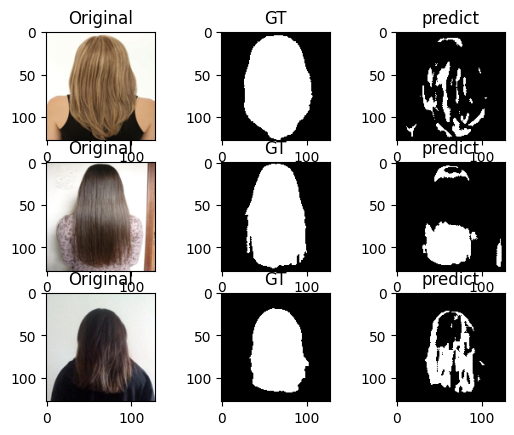

In [62]:
#Load trained model if necessary
#model = load_model('bce_50epochs_conv6a_model.h5')

n = 3
treshold = 0.5

pred = model.predict(X_test)
#Get predicted masks
pred_mask = ((pred > treshold) * 255.)
pred_mask = np.repeat(pred_mask, 3, axis=3)

fig, axes = plt.subplots(nrows=n, ncols=3)
for i in range(n*3):
    plt.subplot(3,3,i+1)
    if i % 3 == 0:
        plt.imshow(X_test[i//3])
        plt.title("Original")
    elif i % 3 == 1:
        plt.imshow(np.repeat(y_test[i//3][:,:,np.newaxis],3, axis=2))
        plt.title("GT")
    else:
        plt.imshow(pred_mask[i//3])
        plt.title("predict")